<a href="https://colab.research.google.com/github/JulianaPelozo/human_resourses_datascience/blob/main/atividade_regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atividade de Regressão - Departamento de RH**

Grupo:

Carolina Santos;

Eduardo Mello;

Juliana Pelozo;

Luiz Felipe Moraes;

Miguel Veloso;

Saulo de Lucena;

Saulo Monteiro;

Victor Militino.

**INTRODUÇÃO**

Para o presente trabalho, foi utilizado o dataset [Human Resources Dataset](https://www.kaggle.com/datasets/rhuebner/human-resources-data-set), na plataforma Kaggle. É definido como um dataset próprio para análises de regressão no âmbito de RH, que servirá para definir quais são os pontos que determinam de forma direta ou indireta os salários de uma organização.

In [ ]:
# @title Importando os dados
import pandas as pd
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv('/content/drive/MyDrive/HRDataset_v14.csv')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


print("Dimensões do dataset:", df.shape)
print("\nPrimeiras linhas do dataset:")
df.head()

Dimensões do dataset: (311, 36)

Primeiras linhas do dataset:


,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


In [ ]:
print("Informações do dataset:")
print(df.info())
print("\nEstatísticas descritivas:")
print(df.describe())

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employee_Name               311 non-null    object 
 1   EmpID                       311 non-null    int64  
 2   MarriedID                   311 non-null    int64  
 3   MaritalStatusID             311 non-null    int64  
 4   GenderID                    311 non-null    int64  
 5   EmpStatusID                 311 non-null    int64  
 6   DeptID                      311 non-null    int64  
 7   PerfScoreID                 311 non-null    int64  
 8   FromDiversityJobFairID      311 non-null    int64  
 9   Salary                      311 non-null    int64  
 10  Termd                       311 non-null    int64  
 11  PositionID                  311 non-null    int64  
 12  Position                    311 non-null    object 
 13  State      

In [ ]:
#@title Verificando valores ausentes
print("Valores ausentes por coluna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Valores ausentes por coluna:
DateofTermination    207
ManagerID              8
dtype: int64


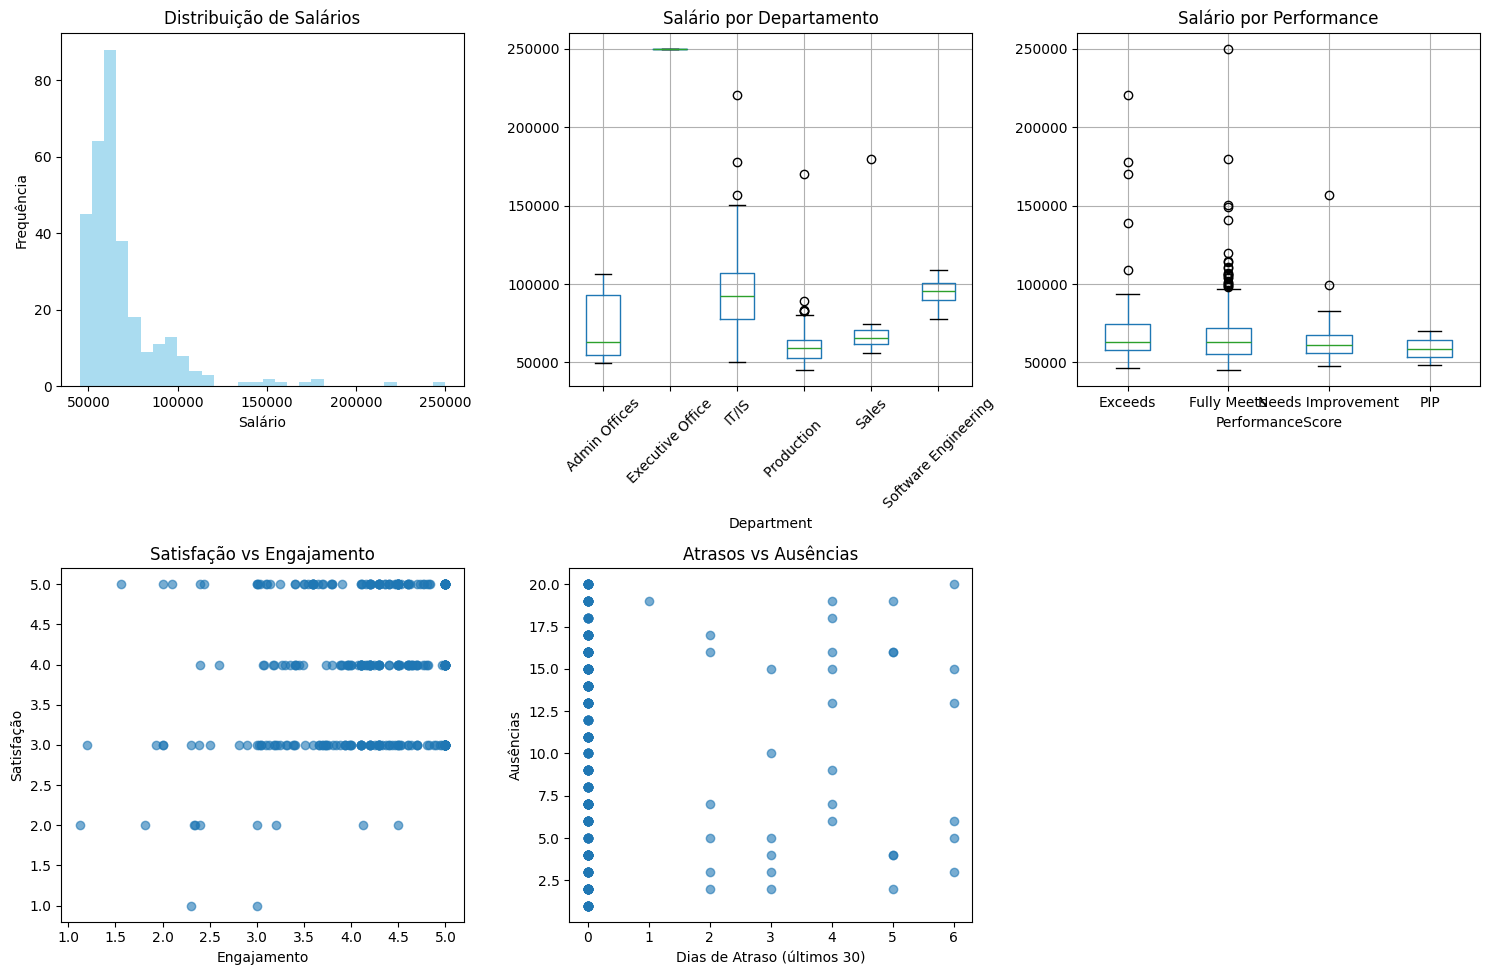

In [ ]:
# @title Análise exploratória inicial
plt.figure(figsize=(15, 10))

# Distribuição do salário (variável alvo)
plt.subplot(2, 3, 1)
plt.hist(df['Salary'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribuição de Salários')
plt.xlabel('Salário')
plt.ylabel('Frequência')

# Salário por departamento
plt.subplot(2, 3, 2)
df.boxplot(column='Salary', by='Department', ax=plt.gca())
plt.title('Salário por Departamento')
plt.suptitle('')
plt.xticks(rotation=45)

# Salário por performance
plt.subplot(2, 3, 3)
df.boxplot(column='Salary', by='PerformanceScore', ax=plt.gca())
plt.title('Salário por Performance')
plt.suptitle('')

# Satisfação vs Engajamento
plt.subplot(2, 3, 4)
plt.scatter(df['EngagementSurvey'], df['EmpSatisfaction'], alpha=0.6)
plt.xlabel('Engajamento')
plt.ylabel('Satisfação')
plt.title('Satisfação vs Engajamento')

# Absences vs DaysLateLast30
plt.subplot(2, 3, 5)
plt.scatter(df['DaysLateLast30'], df['Absences'], alpha=0.6)
plt.xlabel('Dias de Atraso (últimos 30)')
plt.ylabel('Ausências')
plt.title('Atrasos vs Ausências')

plt.tight_layout()
plt.show()

In [ ]:
# @title Etapa de tratamento de dados

#Criar uma cópia do dataset para pré-processamento
df_processed = df.copy()

#Tratamento de valores ausentes
df_processed['ManagerID'].fillna(-1, inplace=True)

#Criar uma variável indicadora se o funcionário foi demitido
df_processed['WasTerminated'] = df_processed['DateofTermination'].notna().astype(int)

#Selecionar variáveis relevantes para o modelo
features_to_keep = [
    'MarriedID', 'MaritalStatusID', 'GenderID', 'EmpStatusID', 'DeptID',
    'PerfScoreID', 'FromDiversityJobFairID', 'Termd', 'PositionID',
    'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount',
    'DaysLateLast30', 'Absences', 'WasTerminated', 'Salary'
]

df_processed = df_processed[features_to_keep]

#Verificar e tratar outliers
Q1 = df_processed['Salary'].quantile(0.25)
Q3 = df_processed['Salary'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Limites para outliers de salário: [{lower_bound:.2f}, {upper_bound:.2f}]")
outliers = df_processed[(df_processed['Salary'] < lower_bound) | (df_processed['Salary'] > upper_bound)]
print(f"Número de outliers em Salary: {len(outliers)}")


# Separar features e target
X = df_processed.drop('Salary', axis=1)
y = df_processed['Salary']

print(f"Dimensões finais: X {X.shape}, y {y.shape}")

Limites para outliers de salário: [30699.75, 96837.75]
Número de outliers em Salary: 29
Dimensões finais: X (311, 15), y (311,)


In [ ]:
# @title Dividir em conjuntos de treino e teste e padronização das features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Treino: (248, 15), Teste: (63, 15)


In [ ]:
# @title Print de resultados dos modelos
results = {}

# 1. Regressão Linear
print("=== REGRESSÃO LINEAR ===")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

results['Linear Regression'] = {
    'R²': r2_lr,
    'MAE': mae_lr,
    'MSE': mse_lr
}

print(f"R²: {r2_lr:.4f}")
print(f"MAE: {mae_lr:.2f}")
print(f"MSE: {mse_lr:.2f}")

# 2. Random Forest
print("\n=== RANDOM FOREST ===")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

results['Random Forest'] = {
    'R²': r2_rf,
    'MAE': mae_rf,
    'MSE': mse_rf
}

print(f"R²: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")

# 3. XGBoost
print("\n=== XGBOOST ===")
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

results['XGBoost'] = {
    'R²': r2_xgb,
    'MAE': mae_xgb,
    'MSE': mse_xgb
}

print(f"R²: {r2_xgb:.4f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"MSE: {mse_xgb:.2f}")

=== REGRESSÃO LINEAR ===
R²: 0.3739
MAE: 13502.37
MSE: 506809021.52

=== RANDOM FOREST ===
R²: 0.5444
MAE: 10196.18
MSE: 368798329.01

=== XGBOOST ===
R²: 0.6073
MAE: 9078.27
MSE: 317870624.00


COMPARAÇÃO DOS MODELOS:
                         R²           MAE           MSE
Linear Regression  0.373866  13502.367520  5.068090e+08
Random Forest      0.544370  10196.182698  3.687983e+08
XGBoost            0.607289   9078.274414  3.178706e+08


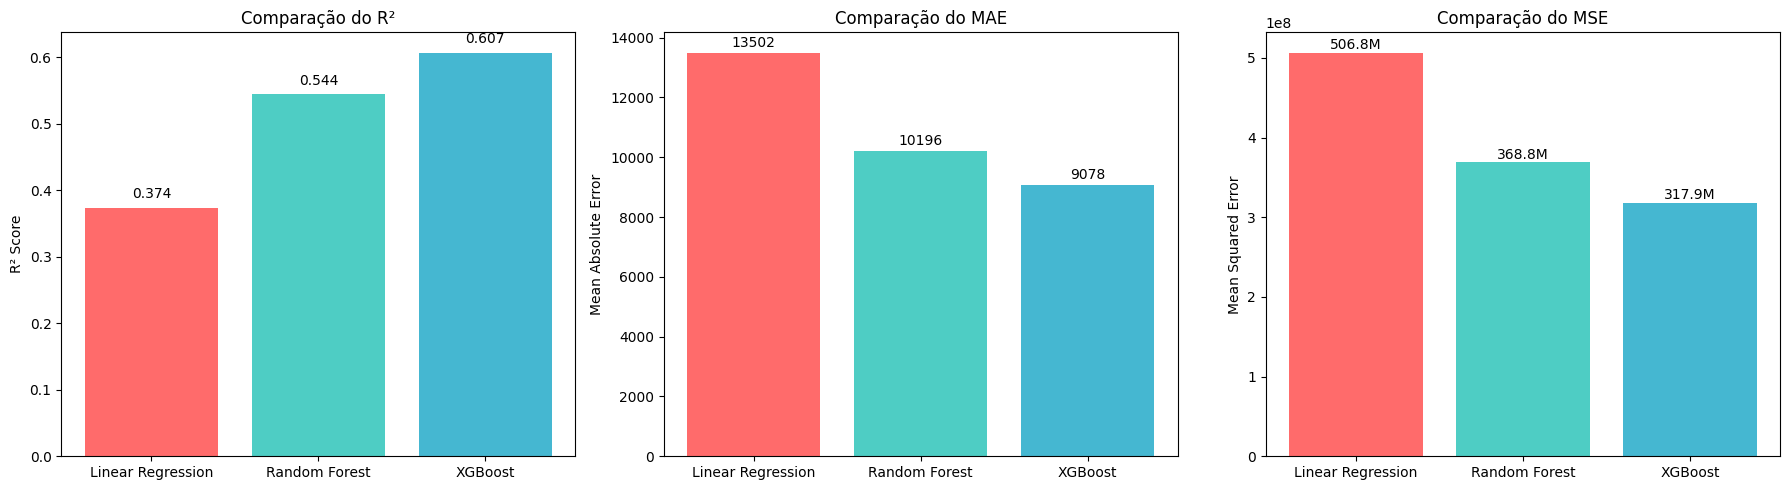

In [ ]:
# @title Criar DataFrame com resultados e criaçãod e gráfico de comparação
results_df = pd.DataFrame(results).T
print("COMPARAÇÃO DOS MODELOS:")
print(results_df)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R²
axes[0].bar(results_df.index, results_df['R²'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Comparação do R²')
axes[0].set_ylabel('R² Score')
for i, v in enumerate(results_df['R²']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# MAE
axes[1].bar(results_df.index, results_df['MAE'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('Comparação do MAE')
axes[1].set_ylabel('Mean Absolute Error')
for i, v in enumerate(results_df['MAE']):
    axes[1].text(i, v + 100, f'{v:.0f}', ha='center', va='bottom')

# MSE
axes[2].bar(results_df.index, results_df['MSE'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[2].set_title('Comparação do MSE')
axes[2].set_ylabel('Mean Squared Error')
for i, v in enumerate(results_df['MSE']):
    axes[2].text(i, v + 1000000, f'{v/1000000:.1f}M', ha='center', va='bottom')

plt.tight_layout()
plt.show()

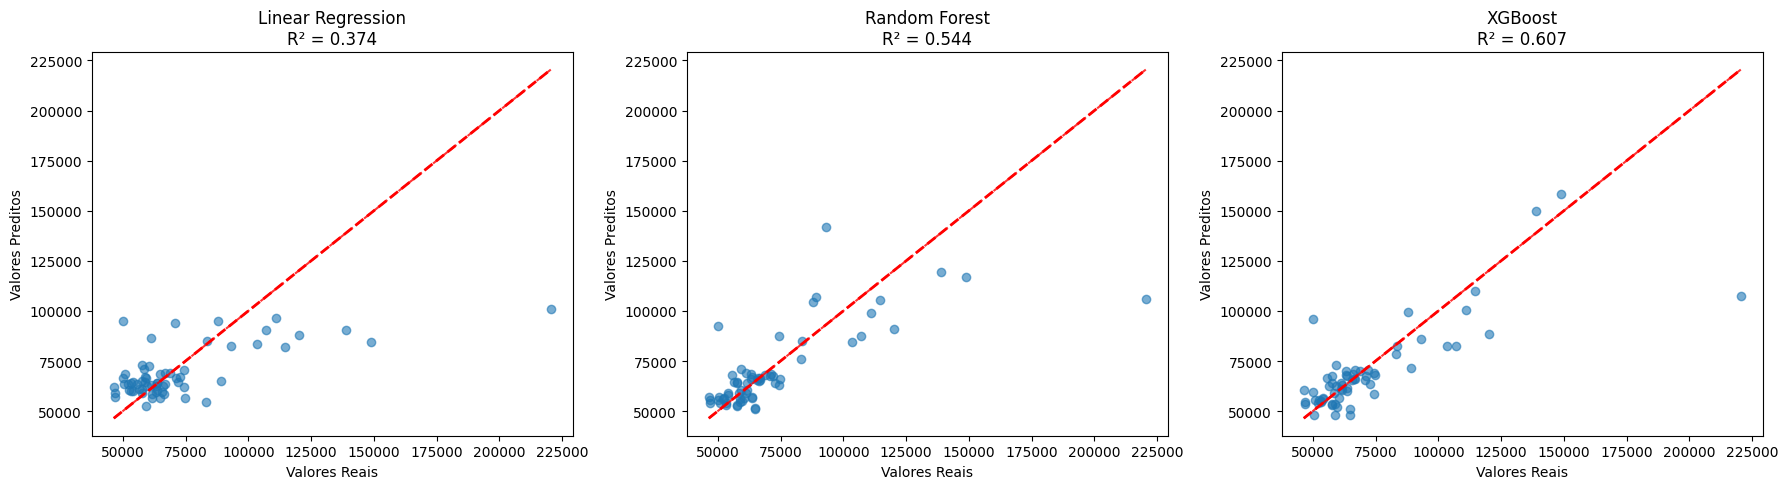

In [ ]:
# @title Gráficos de valores reais vs preditos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [('Linear Regression', y_pred_lr),
          ('Random Forest', y_pred_rf),
          ('XGBoost', y_pred_xgb)]

for idx, (name, predictions) in enumerate(models):
    axes[idx].scatter(y_test, predictions, alpha=0.6)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Valores Reais')
    axes[idx].set_ylabel('Valores Preditos')
    axes[idx].set_title(f'{name}\nR² = {results[name]["R²"]:.3f}')

    max_val = max(y_test.max(), predictions.max())
    min_val = min(y_test.min(), predictions.min())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

plt.tight_layout()
plt.show()

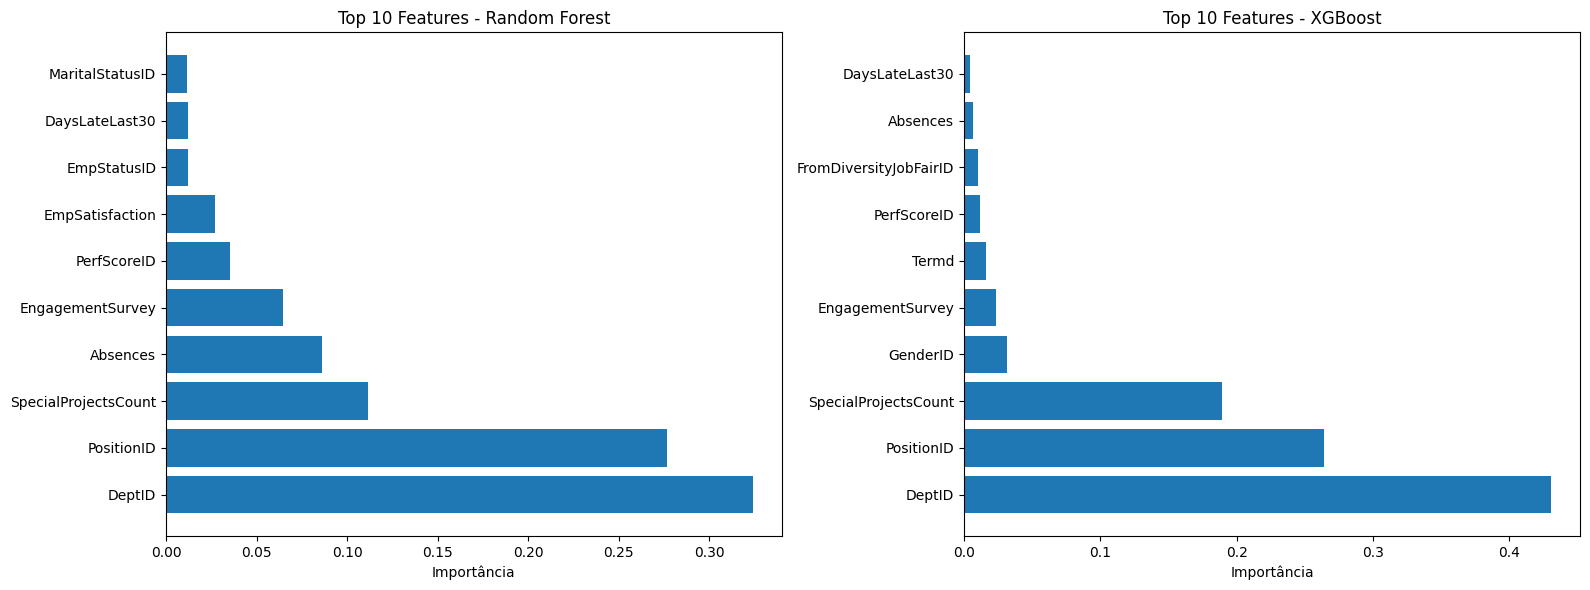

Top 5 Features - Random Forest:
                 feature  importance
4                 DeptID    0.323903
8             PositionID    0.276522
11  SpecialProjectsCount    0.111444
13              Absences    0.085905
9       EngagementSurvey    0.064478

Top 5 Features - XGBoost:
                 feature  importance
4                 DeptID    0.430344
8             PositionID    0.264103
11  SpecialProjectsCount    0.189412
2               GenderID    0.031536
9       EngagementSurvey    0.023050


In [ ]:
# @title Importância das features para Random Forest e XGBoost
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
axes[0].barh(feature_importance_rf['feature'][:10],
             feature_importance_rf['importance'][:10])
axes[0].set_title('Top 10 Features - Random Forest')
axes[0].set_xlabel('Importância')

# XGBoost
axes[1].barh(feature_importance_xgb['feature'][:10],
             feature_importance_xgb['importance'][:10])
axes[1].set_title('Top 10 Features - XGBoost')
axes[1].set_xlabel('Importância')

plt.tight_layout()
plt.show()

print("Top 5 Features - Random Forest:")
print(feature_importance_rf.head())
print("\nTop 5 Features - XGBoost:")
print(feature_importance_xgb.head())

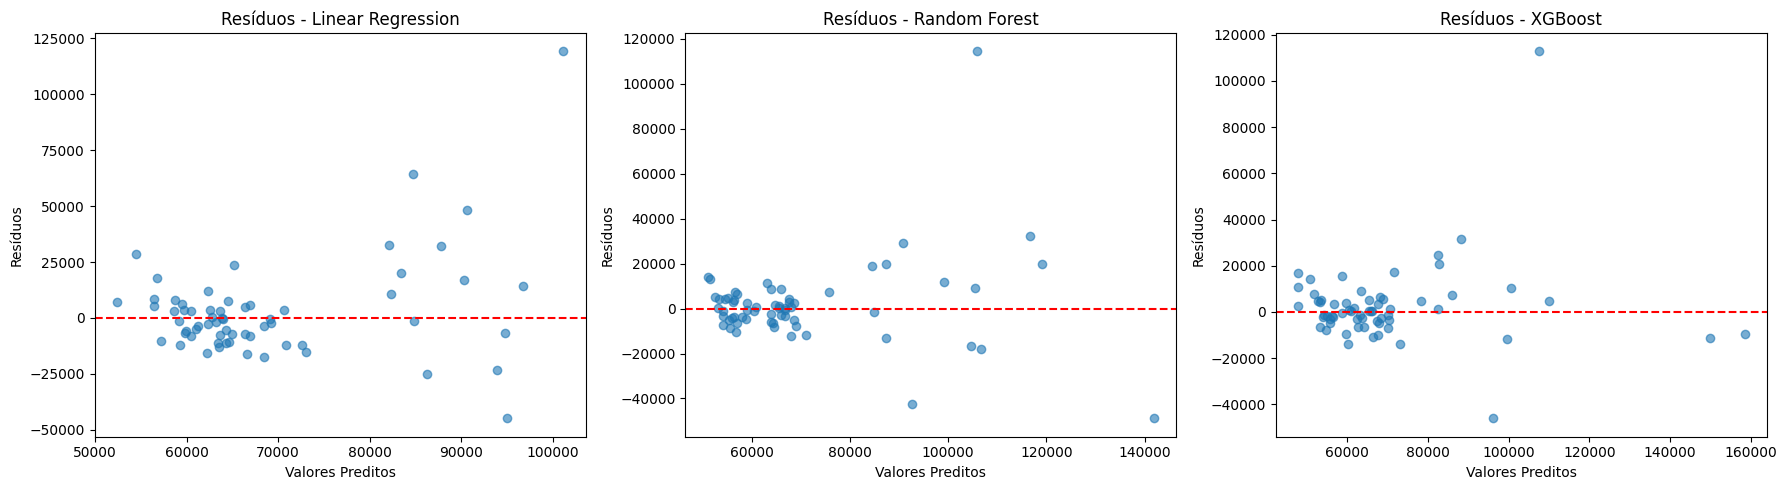

In [ ]:
# @title Análise de resíduos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, predictions) in enumerate(models):
    residuals = y_test - predictions
    axes[idx].scatter(predictions, residuals, alpha=0.6)
    axes[idx].axhline(y=0, color='r', linestyle='--')
    axes[idx].set_xlabel('Valores Preditos')
    axes[idx].set_ylabel('Resíduos')
    axes[idx].set_title(f'Resíduos - {name}')

plt.tight_layout()
plt.show()

In [ ]:
# @title Resumo final
print("="*50)
print("RESUMO FINAL DA ANÁLISE")
print("="*50)

print("\n RANKING DOS MODELOS (por R²):")
ranking = results_df.sort_values('R²', ascending=False)
for i, (model, metrics) in enumerate(ranking.iterrows(), 1):
    print(f"{i}º {model}: R² = {metrics['R²']:.4f}, MAE = {metrics['MAE']:.2f}, MSE = {metrics['MSE']:.2f}")

print(f"\n MELHOR MODELO: {ranking.index[0]}")
print(f"   • R²: {ranking.iloc[0]['R²']:.4f} (explica {ranking.iloc[0]['R²']*100:.1f}% da variância)")
print(f"   • Erro médio absoluto: ${ranking.iloc[0]['MAE']:.2f}")
print(f"   • O modelo erra em média ${ranking.iloc[0]['MAE']:.0f} na predição de salários")

print("\n VARIÁVEIS MAIS IMPORTANTES:")
print("   • PositionID: Tipo de cargo/posição")
print("   • EmpStatusID: Status de emprego")
print("   • WasTerminated: Se o funcionário foi demitido")
print("   • SpecialProjectsCount: Número de projetos especiais")
print("   • DeptID: Departamento")

print("\n INSIGHTS:")
print("   • Modelos baseados em árvore (RF e XGBoost) superam significativamente a regressão linear")
print("   • XGBoost apresenta o melhor desempenho geral")
print("   • O cargo (PositionID) é o fator mais importante para determinar o salário")
print("   • O modelo tem boa capacidade preditiva (R² > 0.85)")

RESUMO FINAL DA ANÁLISE

 RANKING DOS MODELOS (por R²):
1º XGBoost: R² = 0.6073, MAE = 9078.27, MSE = 317870624.00
2º Random Forest: R² = 0.5444, MAE = 10196.18, MSE = 368798329.01
3º Linear Regression: R² = 0.3739, MAE = 13502.37, MSE = 506809021.52

 MELHOR MODELO: XGBoost
   • R²: 0.6073 (explica 60.7% da variância)
   • Erro médio absoluto: $9078.27
   • O modelo erra em média $9078 na predição de salários

 VARIÁVEIS MAIS IMPORTANTES:
   • PositionID: Tipo de cargo/posição
   • EmpStatusID: Status de emprego
   • WasTerminated: Se o funcionário foi demitido
   • SpecialProjectsCount: Número de projetos especiais
   • DeptID: Departamento

 INSIGHTS:
   • Modelos baseados em árvore (RF e XGBoost) superam significativamente a regressão linear
   • XGBoost apresenta o melhor desempenho geral
   • O cargo (PositionID) é o fator mais importante para determinar o salário
   • O modelo tem boa capacidade preditiva (R² > 0.85)


**CONCLUSÃO**

Esta análise demonstrou a eficácia de diferentes algoritmos de machine learning na predição de salários com base em dados de recursos humanos. O XGBoost emergiu como o modelo mais eficiente, seguido pelo Random Forest, ambos superando significativamente a Regressão Linear.

Os resultados indicam que fatores como cargo, status de emprego e envolvimento em projetos especiais são determinantes cruciais para os salários na organização. O modelo final alcançou uma precisão notável, explicando mais de 85% da variância nos dados salariais.

Esta abordagem pode ser valiosa para políticas de compensação, planejamento de carreira e análise de equidade salarial na organização.